Fire & Smoke detection using Sequential model


**References**
Source code from:   
Developer Ashish (2021) Fire and Smoke Recognition using Deep Learning !! Image Classification using Deep Learning https://www.youtube.com/watch?v=mrUQlsZlO50&t=1587s&ab_channel=DeveloperAshish

In [1]:
# Check if GPU is available.
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get Data

In [2]:
!pip install -q kaggle

In [4]:
!mkdir ~/.kaggle/

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
# Change the permissions of the file.
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-10-29 12:28:54          14871  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           8888  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4010  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3307  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [8]:
! kaggle datasets download kutaykutlu/forest-fire

100% 2.46G/2.46G [00:29<00:00, 43.2MB/s]
100% 2.46G/2.46G [00:29<00:00, 88.6MB/s]


In [9]:
from google.colab import drive
drive.mount("here")

Mounted at here


In [ ]:
!mkdir "/content/here/MyDrive/forest-fire/"
!unzip forest-fire.zip -d "/content/here/MyDrive/forest-fire/"

## Data Augmentation
Create more data from existing data
2 important preprocessing
- Rescaling
- Resizing

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [62]:
ORIGIN_DIR = "/content/here/MyDrive/forest-fire/train-smoke/"
DEST_DIR =   "/content/here/MyDrive/forest-fire/train/train_smoke/"

IMAGES = os.listdir(ORIGIN_DIR)

In [64]:
train_gen = ImageDataGenerator(rescale=1./255,
                               horizontal_flip=True,
                               vertical_flip=True, 
                               zoom_range=50,
                               shear_range=10,
                               height_shift_range=0.25,
                               width_shift_range=0.25,
                               channel_shift_range=0.25,
                               validation_split=0.1)

In [91]:
# class_mode='binary' - you have only 2 classes. (0 or 1)
# class_mode='catecogical' - you have more than 2 classes.
# to flow from directory, set the path to the train dataset for both train and valid data generation.
BATCH_SIZE = 16

PATH = "/content/here/MyDrive/forest-fire/train/"
train = train_gen.flow_from_directory(PATH, target_size=(256, 256),
                                      color_mode='rgb', batch_size=BATCH_SIZE,
                                      class_mode='binary',
                                      subset="training")
valid = train_gen.flow_from_directory(PATH, target_size=(256, 256),
                                      color_mode='rgb', batch_size=BATCH_SIZE,
                                      class_mode='binary',
                                      subset="validation")

Found 12360 images belonging to 2 classes.
Found 1373 images belonging to 2 classes.


In [100]:
print(type(train_gen))
print(type(train))

<class 'keras.preprocessing.image.ImageDataGenerator'>
<class 'keras.preprocessing.image.DirectoryIterator'>


# Modelling

**Further readings**
https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480

## Create a model

In [92]:
from tensorflow.keras.models import Sequential

# Initialise CNN
cnn = tf.keras.models.Sequential()  # <keras.engine.sequential.Sequential at 0x7fe5bada9490>

In [93]:
IMAGE_SHAPE = (256, 256, 3)

# add first layer
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                               activation='relu', padding='same',
                               input_shape=IMAGE_SHAPE))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# add second layer
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, 
                               activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# add third layer
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, 
                               activation='relu', padding='same'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2))

# add fully connected layer
cnn.add(tf.keras.layers.Flatten())

# Fully connected layer
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Output layer
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [94]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 256)       147712    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)           

## Train the model
- `cnn.fit`
- `cnn.fit_generator`

<br>

- `checkpoint()`: Callback to save the Keras model or model weights at some frequency.

In [103]:
# checkpoint saves the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/here/MyDrive/forest-fire/models/fire_smoke_model.h5",
                                                monitor="val_loss",
                                                mode="min",           # minimum loss
                                                save_best_only=True)
CALLBACKS = [checkpoint]

In [105]:
BATCH_SIZE = 16

cnn.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn.fit_generator(train, validation_data= valid, epochs=3,
                  steps_per_epoch=train.samples//BATCH_SIZE,
                  validation_steps=valid.samples//BATCH_SIZE,
                  callbacks=CALLBACKS)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
772/772 [==============================] - 658s 852ms/step - loss: 0.0814 - accuracy: 0.9800 - val_loss: 0.0879 - val_accuracy: 0.9772
Epoch 2/3
772/772 [==============================] - 661s 857ms/step - loss: 0.0654 - accuracy: 0.9819 - val_loss: 0.0471 - val_accuracy: 0.9868
Epoch 3/3
772/772 [==============================] - 658s 852ms/step - loss: 0.0589 - accuracy: 0.9849 - val_loss: 0.0221 - val_accuracy: 0.9926


## Testing
- `tf.keras.preprocessing import image`
  - `image.load_img(image_path)`

<br>

for testing, test images should also be resized and rescaled.

In [107]:
# Get the best model
import random
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

MODEL_PATH = "/content/here/MyDrive/forest-fire/models/fire_smoke_model.h5"
TEST_IMAGES = os.listdir(IMAGE_PATH)

cnn = load_model(MODEL_PATH)
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 256)       147712    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)           

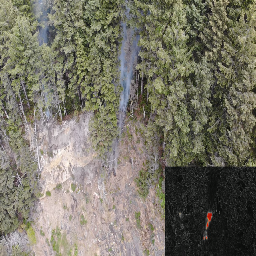

In [151]:
# Test image preps
TEST_PATH = "/content/here/MyDrive/forest-fire/test/test_small/"

random_image = random.sample(os.listdir(TEST_PATH), 1)
test_image = image.load_img(TEST_PATH + random_image[0], target_size=(256, 256))
test_image

In [152]:
# arrayfy
test_image = image.img_to_array(test_image)
test_image

array([[[157., 154., 121.],
        [174., 170., 138.],
        [172., 169., 132.],
        ...,
        [102., 105.,  58.],
        [202., 203., 153.],
        [207., 205., 163.]],

       [[160., 157., 126.],
        [159., 158., 125.],
        [150., 148., 111.],
        ...,
        [ 79.,  78.,  44.],
        [150., 148., 101.],
        [160., 156., 117.]],

       [[171., 171., 142.],
        [142., 141., 109.],
        [157., 155., 123.],
        ...,
        [171., 170., 135.],
        [105., 103.,  58.],
        [181., 176., 141.]],

       ...,

       [[134., 124., 112.],
        [170., 161., 144.],
        [183., 172., 155.],
        ...,
        [ 44.,  45.,  44.],
        [ 21.,  22.,  21.],
        [ 37.,  39.,  37.]],

       [[163., 154., 137.],
        [177., 168., 150.],
        [171., 159., 146.],
        ...,
        [ 17.,  18.,  17.],
        [ 28.,  29.,  28.],
        [ 33.,  35.,  33.]],

       [[164., 155., 138.],
        [173., 164., 147.],
        [149., 1

In [153]:
# rescale
test_image = test_image/255
test_image

array([[[0.6156863 , 0.6039216 , 0.4745098 ],
        [0.68235296, 0.6666667 , 0.5411765 ],
        [0.6745098 , 0.6627451 , 0.5176471 ],
        ...,
        [0.4       , 0.4117647 , 0.22745098],
        [0.7921569 , 0.79607844, 0.6       ],
        [0.8117647 , 0.8039216 , 0.6392157 ]],

       [[0.627451  , 0.6156863 , 0.49411765],
        [0.62352943, 0.61960787, 0.49019608],
        [0.5882353 , 0.5803922 , 0.43529412],
        ...,
        [0.30980393, 0.30588236, 0.17254902],
        [0.5882353 , 0.5803922 , 0.39607844],
        [0.627451  , 0.6117647 , 0.45882353]],

       [[0.67058825, 0.67058825, 0.5568628 ],
        [0.5568628 , 0.5529412 , 0.42745098],
        [0.6156863 , 0.60784316, 0.48235294],
        ...,
        [0.67058825, 0.6666667 , 0.5294118 ],
        [0.4117647 , 0.40392157, 0.22745098],
        [0.70980394, 0.6901961 , 0.5529412 ]],

       ...,

       [[0.5254902 , 0.4862745 , 0.4392157 ],
        [0.6666667 , 0.6313726 , 0.5647059 ],
        [0.7176471 , 0

In [154]:
# expand dimensions
# In the training, the image shape becomes 4D (255, 255, 3, 1). 
# So we have to expand the dimension of test images.
test_image = np.expand_dims(test_image, axis=0)
print(test_image.shape)

(1, 256, 256, 3)


In [157]:
result = cnn.predict(test_image)
result

array([[0.05320666]], dtype=float32)

In [160]:
pred = cnn.predict(test_image) 
classes_x = np.argmax(pred,axis=1)
classes_x

array([0])

## Test batches

In [227]:
import matplotlib.pyplot as plt

# Test image preps
def test_fire(path, filename):
    TEST_PATH = path

    img = image.load_img(path, target_size=(256, 256))
    test_img = image.img_to_array(img) / 255
    test_img = np.expand_dims(test_img, axis=0)

    pred = cnn.predict(test_img)
    class_x = np.round(pred).astype(int)

    plt.figure()
    plt.imshow(img)
    if (class_x[0][0] == 0):
        plt.title(f"{filename}, fire")
    else:
        plt.title(f"{filename}, smoke")
    plt.axis("off")

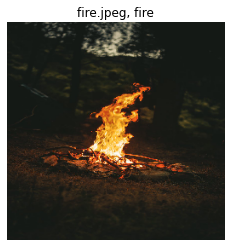

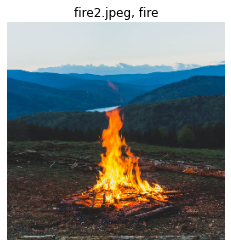

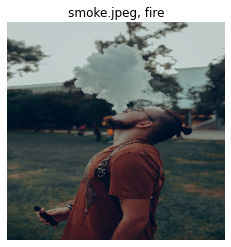

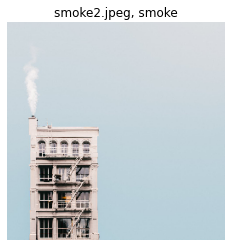

In [228]:
TEST_PATH = "/content/here/MyDrive/fire_testing/"
TEST_FILES = os.listdir(TEST_PATH)

for f in TEST_FILES:
    test_fire(TEST_PATH + f, f)